## Tratamento e Modelagem dos dados: Avaliação da Qualidade do Ar e Poluição

<div style="text-align: center;">
  <img src="../images/data_creaning.png" alt="Texto alternativo" width="800">
</div>

Neste notebook faremos o tratamento dos dados, aplicaremos o pré-processamento e a aplicação de modelos de aprendizado de máquina, a fim de modelar a variável de qualidade do ar.

- No tratamento de dados foi necessário fazer modifições na coluna de temperatura, a justificava advem do (EDA);
- No pré-processamento foi aplicado a padronização StandardScaler para os nossos Features e o OrdinalEncoder para o nosso Targer(que é uma variável qualitativa ordinal).
- Na modelagem foram utilizados diversos modelos e foi realizado a combinação de modelos, o que resultou em um modelo ótimo, todos os modelos foram salvos em artifacts.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Palette Setting
color_palette = ['#333333', '#4F4F4F', '#6B6B6B', '#878787', '#A3A3A3', '#BFBFBF']
# Setting as the palette
sns.set_palette(sns.color_palette(color_palette))
# Display
sns.color_palette(color_palette)

[(0.2, 0.2, 0.2),
 (0.30980392156862746, 0.30980392156862746, 0.30980392156862746),
 (0.4196078431372549, 0.4196078431372549, 0.4196078431372549),
 (0.5294117647058824, 0.5294117647058824, 0.5294117647058824),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (0.7490196078431373, 0.7490196078431373, 0.7490196078431373)]

In [16]:
dataset = pd.read_csv("../input/data.csv", sep=',')
dataset.head(2)

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate


## 1. Tratamento dos dados

Nesta seção, iremos fazer ajustes no banco de dados. Faremos modificações de acordo com as incossistências obtidas na análise descritiva de dados (EDA).

### 1.2 Temperature

Na etapa da (EDA) foram achados valores a cima do valor de 100% de umidade, mas eram valores próximos a 100. Logo, utilizaremos o valor de 100% para os valores que estão a cima do valor de 100% de umidade.

In [17]:
dataset[dataset['Temperature']>=100] = 100

## 2. Divisão em Treino e Teste

In [18]:
features_names = ['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Proximity_to_Industrial_Areas',\
                  'Population_Density']

target_name = 'Air Quality'

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset[features_names], dataset[target_name],\
                                                     test_size=0.2, random_state=42)

## 3. Pré-Processamento

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

pipeline_features = Pipeline([
    ('scaler', StandardScaler())
])

pipeline_target = Pipeline([
    ('ordinal', OrdinalEncoder())  
])

X_train_scaled = pipeline_features.fit_transform(X_train)
X_test_scaled = pipeline_features.fit_transform(X_test)

y_train_encode = pipeline_target.fit_transform(np.array(y_train).reshape(-1,1))
y_test_encode = pipeline_target.fit_transform(np.array(y_test).reshape(-1,1))

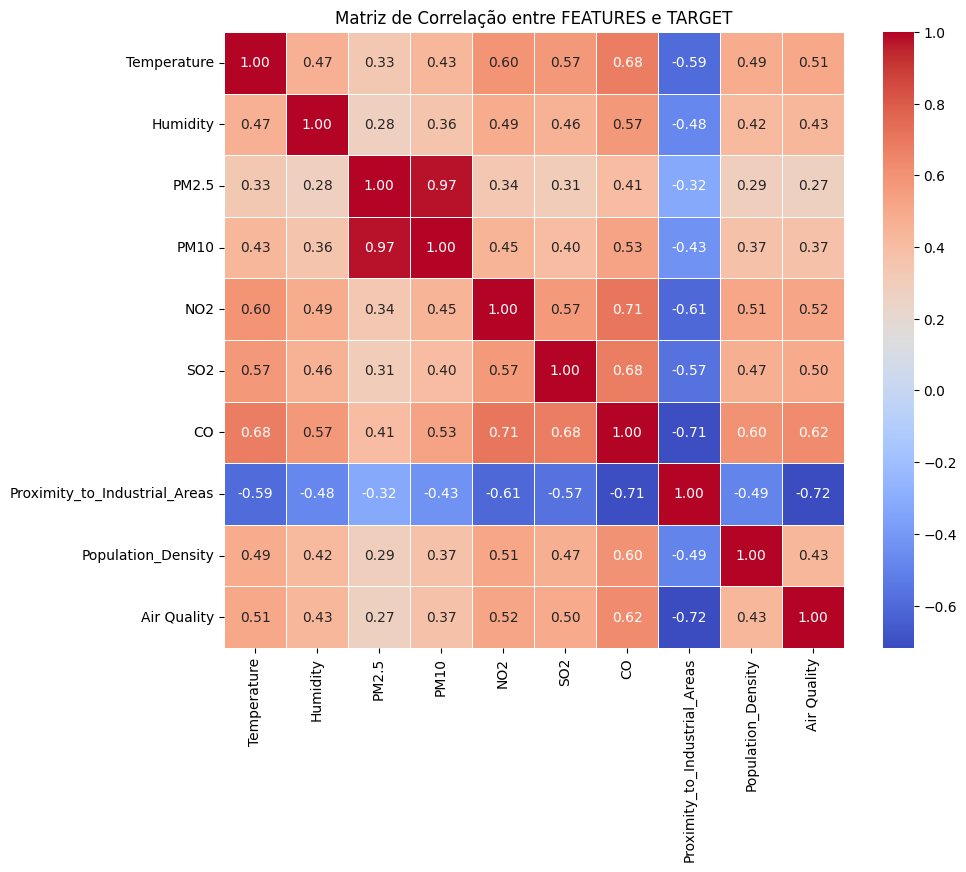

In [21]:
data = np.column_stack([X_train_scaled, y_train_encode])  

columns = ['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Proximity_to_Industrial_Areas',\
                  'Population_Density', 'Air Quality']
df = pd.DataFrame(data, columns=columns)

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação entre FEATURES e TARGET')
plt.show()

## 4. Modelagem

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


models = {
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(probability=True),
    'KNN Classifier': KNeighborsClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'XGBoost': xgb.XGBClassifier(),  
    'MLP Classifier': MLPClassifier(max_iter=1000),  
}

In [23]:
results = {}
predictions = {}
roc_auc_scores = {}
accuracy_scores = {}

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train_encode.ravel())
    predicao = model.predict(X_test_scaled)
    predictions[model_name] = predicao
    probabilidade = model.predict_proba(X_test_scaled)

    roc_auc_scores[model_name] = roc_auc_score(y_test_encode.ravel(), probabilidade, multi_class='ovr', average='macro')
    accuracy_scores[model_name] = accuracy_score(y_test_encode.ravel(), predictions[model_name])

In [24]:
roc_auc_scores

{'Logistic Regression': np.float64(0.9919845257815304),
 'SVC': np.float64(0.993013461018295),
 'KNN Classifier': np.float64(0.9753343730681763),
 'Random Forest Classifier': np.float64(0.9940195168889585),
 'Decision Tree Classifier': np.float64(0.9262792131245001),
 'XGBoost': np.float64(0.9954519854498288),
 'MLP Classifier': np.float64(0.9928106445526784)}

In [25]:
accuracy_scores

{'Logistic Regression': 0.946,
 'SVC': 0.942,
 'KNN Classifier': 0.923,
 'Random Forest Classifier': 0.96,
 'Decision Tree Classifier': 0.914,
 'XGBoost': 0.956,
 'MLP Classifier': 0.954}

In [26]:
best_combination = max(accuracy_scores, key=accuracy_scores.get)
best_score = accuracy_scores[best_combination]

print(f"A melhor previsão individual é: {best_combination}")
print(f'Melhor accuracy: {best_score:.4f}')

A melhor previsão individual é: Random Forest Classifier
Melhor accuracy: 0.9600


In [27]:
from itertools import combinations
model_combinations = combinations(predictions.items(), 2)

accuracy_scores_combined = {}

for (model_name_1, pred_1), (model_name_2, pred_2) in model_combinations:
    combined_predictions = np.round((pred_1 + pred_2) / 2).astype(int)  
    accuracy_scores_combined[(model_name_1, model_name_2)] = accuracy_score(y_test_encode.ravel(), combined_predictions)

# Exibindo as acurácias das combinações
for model_comb, acc in accuracy_scores_combined.items():
    print(f"Combinação {model_comb}: Acurácia = {acc:.4f}")

Combinação ('Logistic Regression', 'SVC'): Acurácia = 0.9420
Combinação ('Logistic Regression', 'KNN Classifier'): Acurácia = 0.9180
Combinação ('Logistic Regression', 'Random Forest Classifier'): Acurácia = 0.9450
Combinação ('Logistic Regression', 'Decision Tree Classifier'): Acurácia = 0.9120
Combinação ('Logistic Regression', 'XGBoost'): Acurácia = 0.9400
Combinação ('Logistic Regression', 'MLP Classifier'): Acurácia = 0.9410
Combinação ('SVC', 'KNN Classifier'): Acurácia = 0.9140
Combinação ('SVC', 'Random Forest Classifier'): Acurácia = 0.9370
Combinação ('SVC', 'Decision Tree Classifier'): Acurácia = 0.9100
Combinação ('SVC', 'XGBoost'): Acurácia = 0.9380
Combinação ('SVC', 'MLP Classifier'): Acurácia = 0.9370
Combinação ('KNN Classifier', 'Random Forest Classifier'): Acurácia = 0.9170
Combinação ('KNN Classifier', 'Decision Tree Classifier'): Acurácia = 0.8890
Combinação ('KNN Classifier', 'XGBoost'): Acurácia = 0.9170
Combinação ('KNN Classifier', 'MLP Classifier'): Acurácia =

In [28]:
best_combination = max(accuracy_scores_combined, key=accuracy_scores_combined.get)
best_score = accuracy_scores_combined[best_combination]

print(f"A melhor combinação é: {', '.join(best_combination)}")
print(f'Melhor accuracy: {best_score:.4f}')

A melhor combinação é: Random Forest Classifier, XGBoost
Melhor accuracy: 0.9520


## 5. Salvando os melhores modelos

In [29]:
import pickle
import os

os.makedirs('../artifacts', exist_ok=True)

with open('../artifacts/RandomForestClassifier.pkl', 'wb') as f:
    pickle.dump(models['Random Forest Classifier'], f)

with open('../artifacts/XGBoost.pkl', 'wb') as f:
    pickle.dump(models['XGBoost'], f)

## 6. Discurssão dos Resultados

Neste notebook, realizamos o tratamento de dados e a modelagem utilizando diferentes algoritmos de aprendizado de máquina. Os resultados obtidos foram bastante promissores, com acurácias superiores a 90%, o que sugere que tanto a modelagem quanto a metodologia aplicada são adequadas e eficazes para os dados em questão. Entre os modelos avaliados, o Random Forest Classifier se destacou como o mais eficiente. Além disso, uma abordagem combinada, utilizando a média simples das previsões do Random Forest Classifier e do XGBoost, apresentou um desempenho igualmente robusto, oferecendo uma solução potencialmente mais robusta e precisa.